In [13]:
from Softs.Spanve import *
from sklearn.metrics import adjusted_rand_score as ari
target_sample_id = '151672'

adata= sc.read_h5ad(f'./recode/IMPUTEDLIBD/processed/{target_sample_id}.h5ad')
adata = adata_preprocess(adata)
sc.pp.pca(adata)

label_BS = pd.read_csv(f'./recode/IMPUTEDLIBD/BS/{target_sample_id}_BS.out.csv',index_col=0)
label_SG = pd.read_csv(f'./recode/IMPUTEDLIBD/SG/{target_sample_id}.csv',index_col=0)

cluster = AutoCluster()

label_KM = pd.DataFrame(
    {
        'spanve_impute': pd.Series(cluster.fit_predict(X=adata.obsm['spanve.imputed.pca']),index=adata.obs_names),
        'base': pd.Series(cluster.fit_predict(X=adata.obsm['X_pca']),index=adata.obs_names),
    }
)

In [23]:
from sklearn.preprocessing import LabelEncoder
def plot_spatial(value,anndata,ax=None,s=5,add_text=''):
    if ax is None:
        fig,ax = plt.subplots()
    if value.dtype=='object':
        value = LabelEncoder().fit_transform(value)
    spatial_info = anndata.obsm['spatial']
    assert spatial_info.shape[0]==value.shape[0]
    ax.scatter(
        spatial_info[:,0],
        spatial_info[:,1],
        c=value,
        cmap='viridis',
        s=s,
        )
    ax.set_xticks([])
    ax.set_yticks([])
    if add_text:
        ax.text(
            s = add_text,
            x = 0.75,
            y = 0.02,
            transform=ax.transAxes,
            size=8,
        )
    return ax

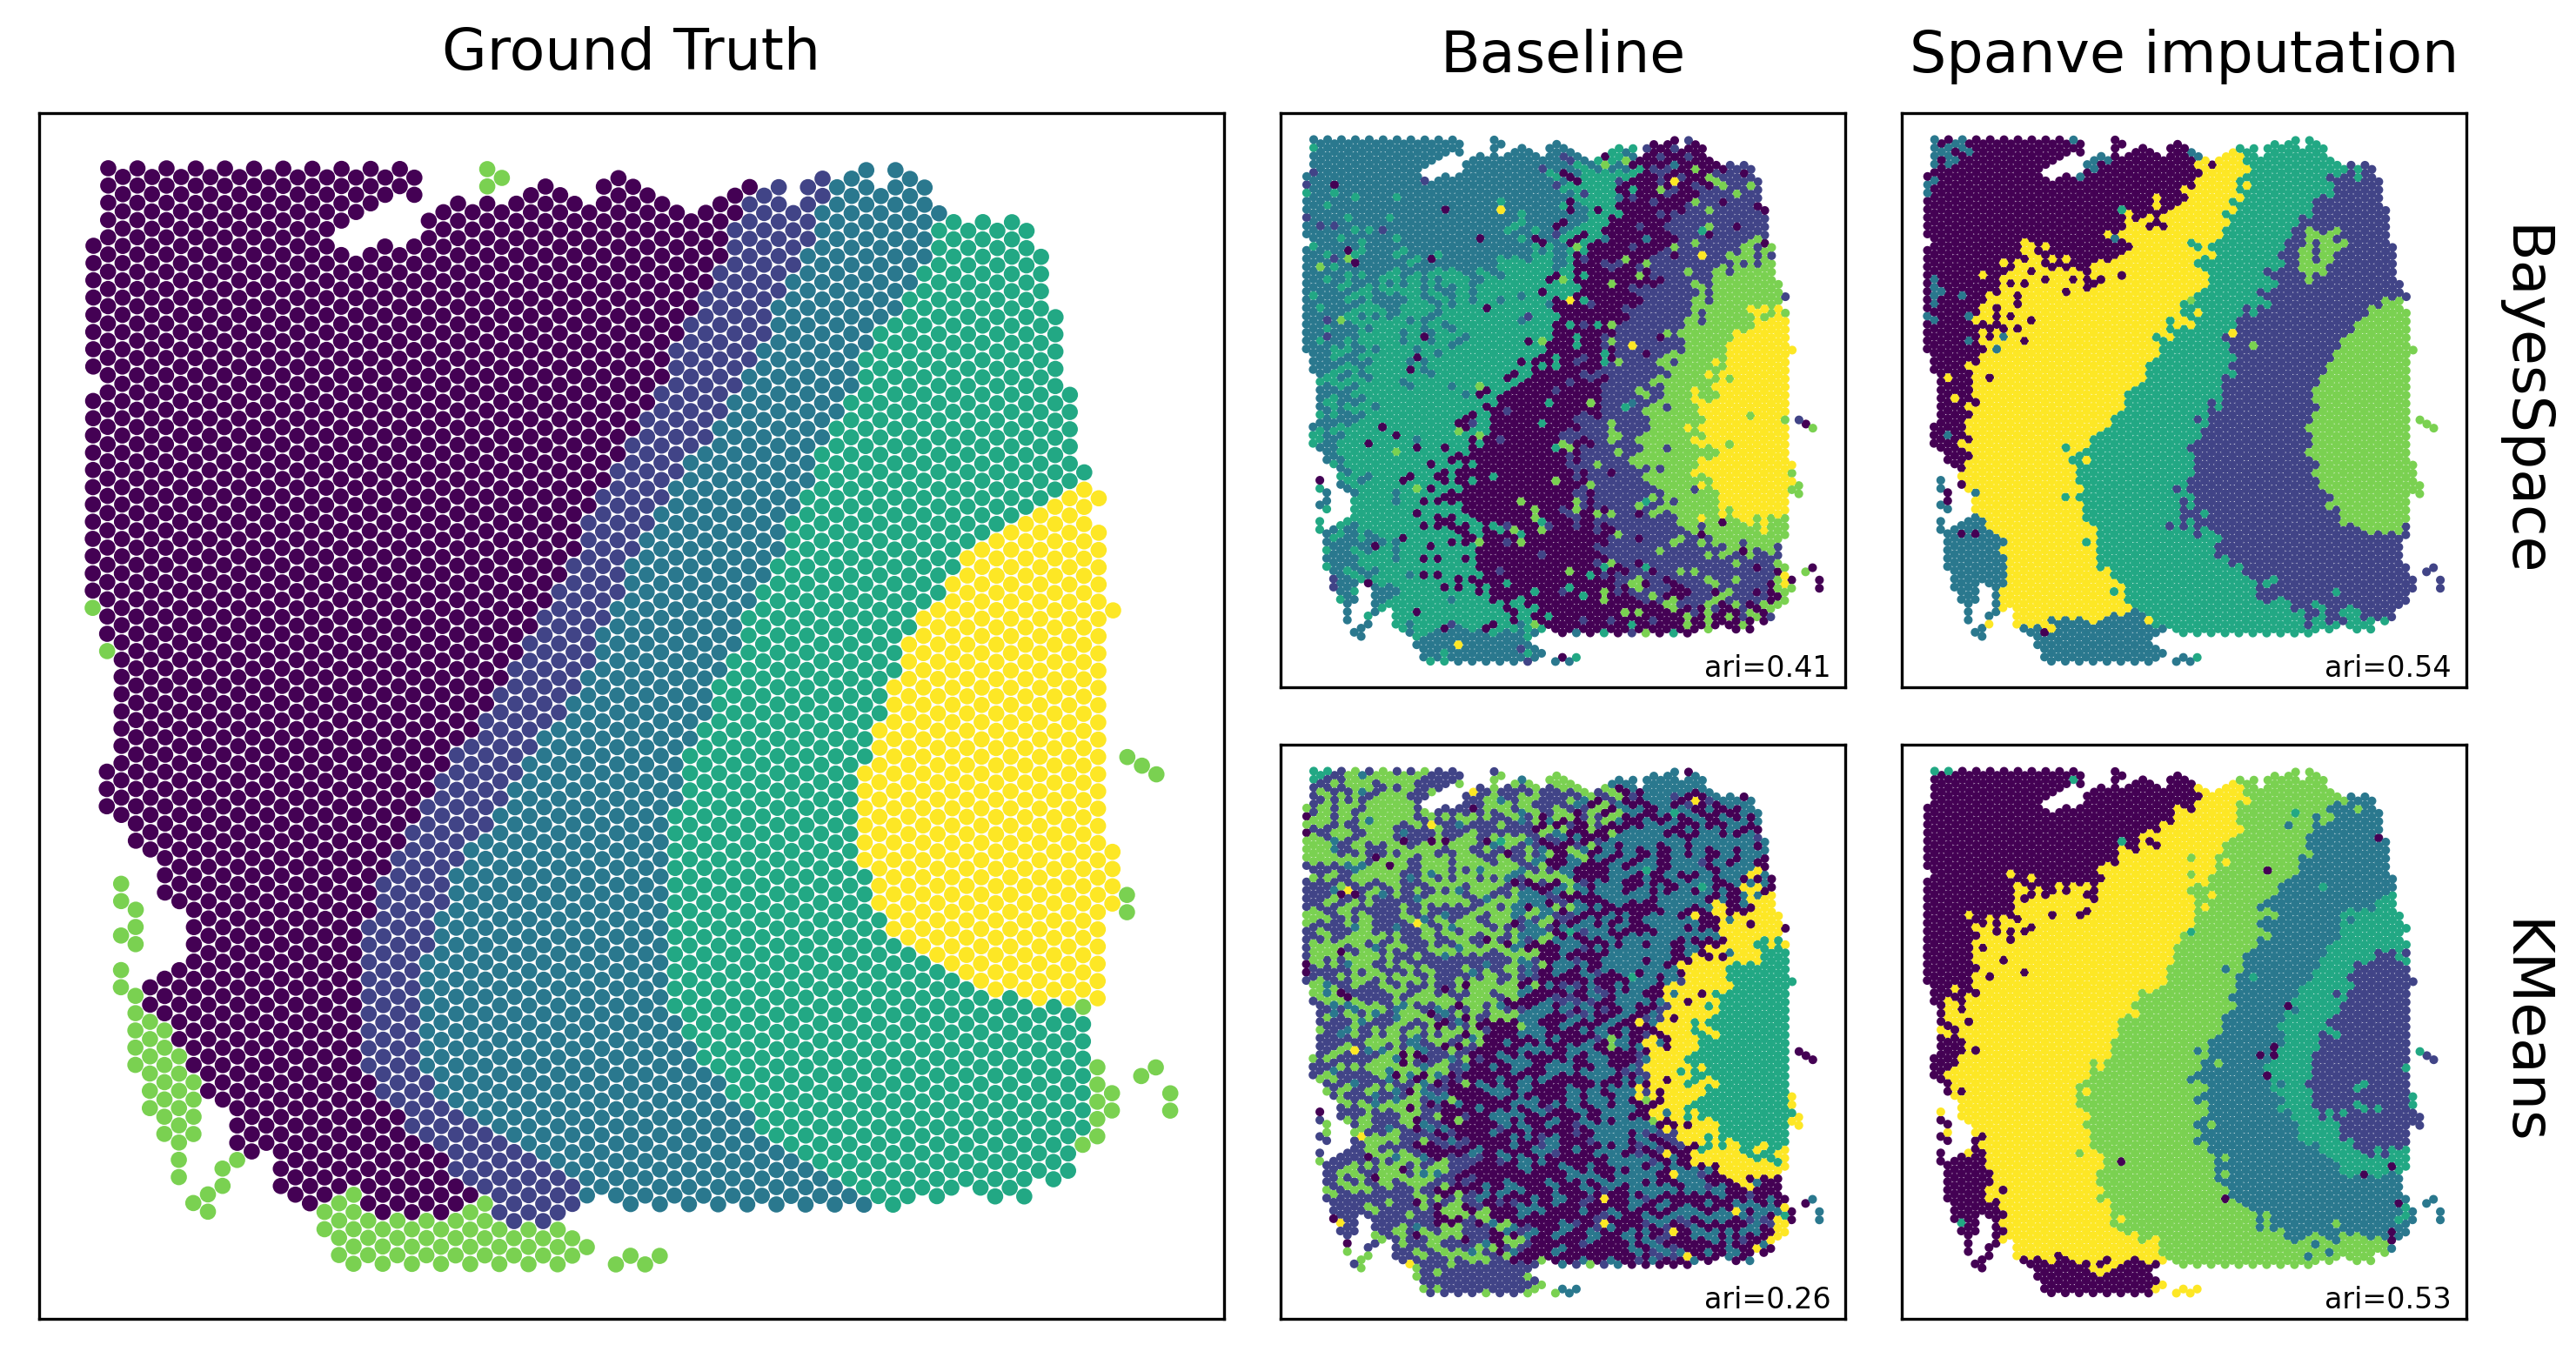

In [24]:
from matplotlib import patches

f = plt.figure(
    dpi=300,
    figsize=(12,6)
)
aspec = f.add_gridspec(
    nrows=2, ncols=4, 
    wspace=0.1, hspace=0.1
)
ax_ground = f.add_subplot(aspec[0:2, 0:2])
ax_BS_base = f.add_subplot(aspec[0, 2])
ax_BS_spi = f.add_subplot(aspec[0, 3])
ax_SG_base = f.add_subplot(aspec[1, 2])
ax_SG_spi = f.add_subplot(aspec[1, 3])

ground = adata.obs['ground_truth']
plot_spatial(ground.values.astype(object),adata,ax=ax_ground,s=12)
for ax,label in zip(
    [ax_BS_spi,ax_BS_base,ax_SG_spi,ax_SG_base],
    [label_BS.iloc[:,0],label_BS.iloc[:,1],label_KM.iloc[:,0],label_KM.iloc[:,1]]
):
    
    plot_spatial(label,adata,ax=ax,s=2,add_text = f'ari={ari(ground,label):.2f}')


text_obj1 = ax_ground.text(
    s='Ground Truth',x=0.5,y=1.05,
    size=16,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_ground.transAxes,
)
text_obj2 = ax_BS_base.text(
    s='Baseline',x=0.5,y=1.1,
    size=16,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_BS_base.transAxes,
)
text_obj3 = ax_BS_spi.text(
    s='Spanve imputation',x=0.5,y=1.1,
    size=16,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_BS_spi.transAxes,
)
text_obj4 = ax_BS_spi.text(
    s='BayesSpace',x=1.1,y=0.5,rotation=-90,
    size=16,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_BS_spi.transAxes,
)

text_obj5 = ax_SG_spi.text(
    s='KMeans',x=1.1,y=0.5,rotation=-90,
    size=16,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_SG_spi.transAxes,
)

In [25]:
f.savefig('./Results/151672_example_impute_clust.pdf',bbox_inches='tight')